<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

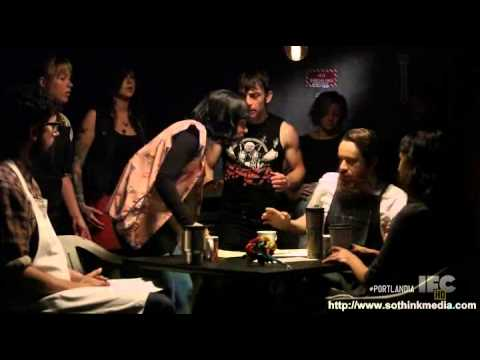

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
import pandas as pd

shops = pd.read_csv('./data/yelp_coffeeshop_review_data.csv')
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [3]:
# Start here 
shops['rating'] = shops['star_rating'].apply(lambda x: x.replace(' star rating', '')).astype('float')
del shops['star_rating']

In [4]:
shops['date'] = shops['full_review_text'].apply(lambda x: x.split()[0])
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: " ".join(x.split()[1:]))

In [5]:
shops.head()

,coffee_shop_name,full_review_text,rating,date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,11/25/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,12/2/2016
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0,11/30/2016
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Howe...,2.0,11/25/2016
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0,12/3/2016


In [6]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [7]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [8]:
shops['tokens'] = shops['full_review_text'].apply(get_lemmas)

In [9]:
shops['tokens']

0       [1, check, love, love, love, atmosphere, corne...
1       [list, Date, Night, Austin, Ambiance, Austin, ...
2       [1, check, list, Brunch, Spots, love, eclectic...
3       [cool, decor, good, drink, nice, seating, over...
4       [1, check, locate, Northcross, mall, shopping,...
5       [1, check, cute, cafe, think, moment, step, fi...
6       [2, check, in, list, Nuptial, Coffee, Bliss, A...
7       [2, check, in, love, place, 5, star, cleanline...
8       [1, check, ok, let, try, approach, pro, music,...
9       [3, check, in, place, show, social, medium, da...
10      [1, check, list, Americano, average, cute, stu...
11      [store, A+, decoration, honestly, coffee, good...
12      [1, check, list, 2016, Time, Charm, Factory, a...
13      [cute, little, cafe, drive, place, time, notic...
14      [beautiful, eccentric, coffee, shop, library, ...
15      [1, check, list, Search, Fantastic, Coffee, wa...
16      [love, atmosphere, frequent, coffee, shop, def...
17      [1, ch

In [10]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [11]:
wc = count(shops['tokens'])

In [12]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
33,coffee,4848,10153,1.0,0.028068,0.028068,0.636555
125,place,3879,6026,2.0,0.016659,0.044728,0.509322
146,good,3590,5393,3.0,0.014909,0.059637,0.471376
140,great,2843,3924,4.0,0.010848,0.070485,0.373293
16,check,3175,3467,5.0,0.009585,0.080070,0.416886


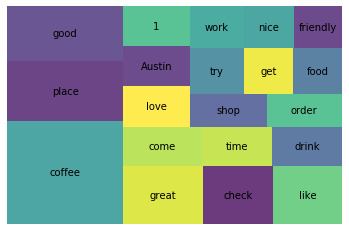

In [15]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [17]:
shops['coffee_shop_name'].nunique()

79

C:\Users\nchib\Anaconda3\envs\U4-S1-NLP\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


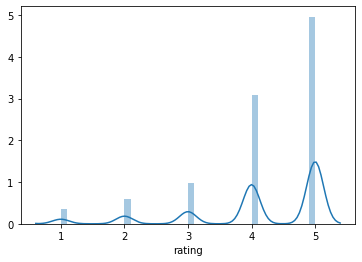

In [19]:
import seaborn as sns

sns.distplot(shops['rating']);

In [20]:
wc_bad = count(shops[shops['rating'] < 4]['tokens'])

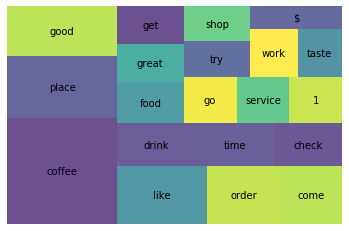

In [23]:
wc_top20_bad = wc_bad[wc_bad['rank'] <= 20]

squarify.plot(sizes=wc_top20_bad['pct_total'], label=wc_top20_bad['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [24]:
wc_good = count(shops[shops['rating'] > 4]['tokens'])

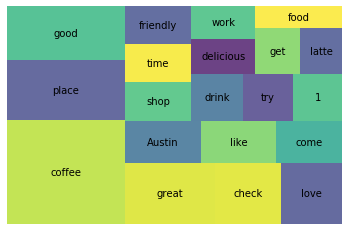

In [25]:
wc_top20_good = wc_good[wc_good['rank'] <= 20]

squarify.plot(sizes=wc_top20_good['pct_total'], label=wc_top20_good['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [37]:
diff = wc_good[['word', 'appears_in_pct']].merge(wc_bad[['word', 'appears_in_pct']], on='word', how='outer', suffixes=('_good', '_bad'))

In [38]:
diff.head()

,word,appears_in_pct_good,appears_in_pct_bad
0,coffee,0.620635,0.631436
1,place,0.491270,0.510840
2,good,0.453704,0.434959
3,great,0.411905,0.234417
4,check,0.387566,0.331301


In [39]:
diff['diff'] = diff['appears_in_pct_good'] - diff['appears_in_pct_bad']

In [40]:
diff.sort_values(by='diff')

,word,appears_in_pct_good,appears_in_pct_bad,diff
7,like,0.237302,0.403794,-0.166492
22,order,0.146561,0.292005,-0.145445
264,bad,0.028042,0.128726,-0.100684
31,go,0.128307,0.228320,-0.100013
137,ask,0.049735,0.149051,-0.099316
52,pretty,0.092857,0.191734,-0.098877
109,$,0.053439,0.147696,-0.094257
30,service,0.140212,0.234417,-0.094206
45,taste,0.101058,0.189702,-0.088644
58,think,0.089418,0.177507,-0.088089


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

